In [158]:
# Imports
import os
import h5py
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Global variables
train_dir = 'svhn_large_data/train'
test_dir = 'svhn_large_data/test'
extra_dir = 'svhn_large_data/extra'

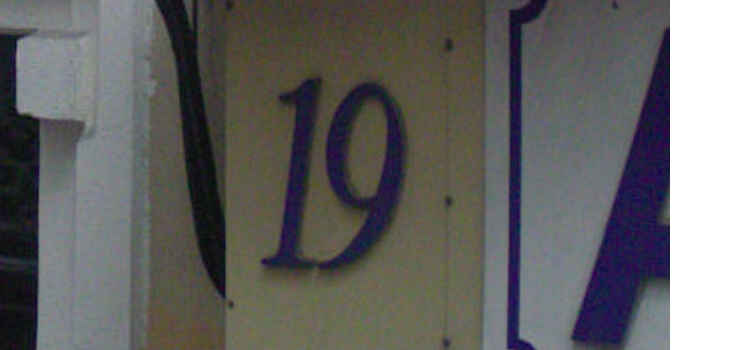

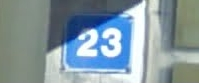

In [157]:
# First two images
display.display(display.Image(train_dir + '/' + str(1) + '.png'), display.Image(train_dir + '/' + str(2) + '.png'))

In [166]:
# Extract data and convert to numpy arrays
train_num = 25000
img_size = 64
channels_num = 1
labels_num = 11
digits_num = 5

# Get metadata
def extract_metadata(dr):
    metadata = {}
    fl = h5py.File(dr + '/digitStruct.mat')
    
    for i in xrange(len([x for x in os.listdir(dr) if x.split('.')[1] == 'png'])):        
        name = fl['digitStruct']['name'][i][0]
        bbox = fl['digitStruct']['bbox'][i][0]
        image_metadata = []
    
        if len(fl[bbox]['label']) == 1:    
            digit_metadata = {}
            digit_metadata['height'] = fl[bbox]['height'][0][0]
            digit_metadata['width'] = fl[bbox]['width'][0][0]
            digit_metadata['top'] = fl[bbox]['top'][0][0]
            digit_metadata['left'] = fl[bbox]['left'][0][0]
            digit_metadata['label'] = fl[bbox]['label'][0][0]
            image_metadata.append(digit_metadata)                    
        else:
            for j in xrange(len(fl[bbox]['label'])):
                digit_metadata = {}
                digit_metadata['height'] = [x for x in fl[fl[bbox]['height'][j][0]]][0][0]
                digit_metadata['width'] = [x for x in fl[fl[bbox]['width'][j][0]]][0][0]
                digit_metadata['top'] = [x for x in fl[fl[bbox]['top'][j][0]]][0][0]
                digit_metadata['left'] = [x for x in fl[fl[bbox]['left'][j][0]]][0][0]
                digit_metadata['label'] = [x for x in fl[fl[bbox]['label'][j][0]]][0][0]
                image_metadata.append(digit_metadata)                    
        
        metadata[''.join(chr(c) for c in fl[name][:])] = image_metadata
    
    return metadata

train_metadata = extract_metadata(train_dir)
test_metadata = extract_metadata(test_dir)

# 29930.png in the training set is the only image with more than 5 digits, so we will treat it as an outlier and remove it
display.display(display.Image(train_dir + '/' + str(29930) + '.png'))
if '29930.png' in train_metadata:
    del train_metadata['29930.png']

# Open images, convert to grayscale, resize, convert to numpy, and normalize
train_X = np.ndarray((train_num, img_size, img_size, channels_num)).astype(np.float32)
train_y = np.ndarray((train_num, digits_num, labels_num))
valid_X = np.ndarray((len(train_metadata) - train_num, img_size, img_size, channels_num)).astype(np.float32)
valid_y = np.ndarray((len(train_metadata) - train_num, digits_num, labels_num))
test_X = np.ndarray((len(test_metadata), img_size, img_size, channels_num)).astype(np.float32)
test_y = np.ndarray((len(test_metadata), digits_num, labels_num))

def img_to_np(img):
    img_gray = img.convert('L')
    img_resized = img_gray.resize((img_size, img_size), Image.ANTIALIAS)
    img_np = np.array(img_resized)
    img_normal = (img_np - (255.0 / 2.0)) / 255.0
    return img_normal.reshape((img_size, img_size, channels_num))

# Training
for i in xrange(1, len(train_X) + 1):
    train_X[i - 1,:,:,:] = img_to_np(Image.open(train_dir + '/' + str(i) + '.png'))
    
    for j in xrange(digits_num):
        if j < len(train_metadata[str(i) + '.png']):
            label = train_metadata[str(i) + '.png'][j]['label']
            train_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            train_y[i - 1,j,:] = np.arange(labels_num) == 10
    
# Validation
for i in xrange(len(valid_X) + 1):
    if i != 4929:  # Account for outlier
        index = i if i < 4929 else i - 1
        valid_X[index,:,:,:] = img_to_np(Image.open(train_dir + '/' + str(i + len(train_X) + 1) + '.png'))

        for j in xrange(digits_num):
            if j < len(train_metadata[str(i + len(train_X) + 1) + '.png']):
                label = train_metadata[str(i + len(train_X) + 1) + '.png'][j]['label']
                index = i if i < 4929 else i - 1
                valid_y[index,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
            else:
                valid_y[index,j,:] = np.arange(labels_num) == 10

# Testing
for i in xrange(1, len(test_X) + 1):
    test_X[i - 1,:,:,:] = img_to_np(Image.open(test_dir + '/' + str(i) + '.png'))
    
    for j in xrange(digits_num):
        if j < len(test_metadata[str(i) + '.png']):
            label = test_metadata[str(i) + '.png'][j]['label']
            test_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            test_y[i - 1,j,:] = np.arange(labels_num) == 10
            
# Make sure we preprocessed correctly
print('Training data shape: %s' % str(train_X.shape))
print('Training labels shape: %s' % str(train_y.shape))
print('Validation data shape: %s' % str(valid_X.shape))
print('Validation labels shape: %s' % str(valid_y.shape))
print('Testing data shape: %s' % str(test_X.shape))
print('Testing labels shape: %s\n' % str(test_X.shape))

print('Digits per image in training set:')
for n in xrange(1, 6):
    print('%d images with %d digits' % (len([5 - len([x for x in train_y[i,:,10] if x == 1]) for i in xrange(l) if 
                                             5 - len([x for x in train_y[i,:,10] if x == 1]) == n]), n))

Training data shape: (25000, 64, 64, 1)
Training labels shape: (25000, 5, 11)
Validation data shape: (8401, 64, 64, 1)
Validation labels shape: (8401, 5, 11)
Testing data shape: (13068, 64, 64, 1)
Testing labels shape: (13068, 64, 64, 1)

Digits per image in training set:
3910 images with 1 digits
13492 images with 2 digits
6528 images with 3 digits
1063 images with 4 digits
7 images with 5 digits


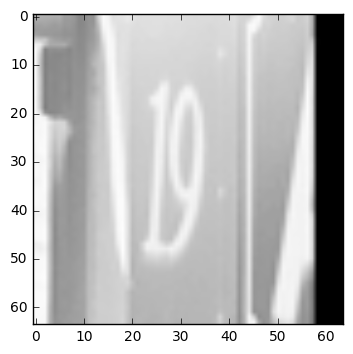

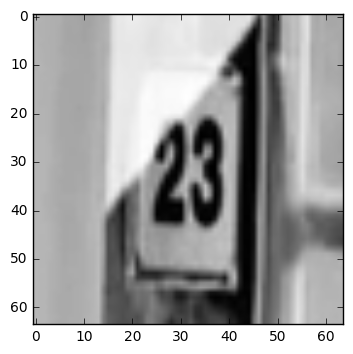

In [162]:
# First two images again
%matplotlib inline  
plt.show(plt.imshow(train_X[0].reshape(img_size, img_size), cmap=plt.cm.Greys))
plt.show(plt.imshow(train_X[1].reshape(img_size, img_size), cmap=plt.cm.Greys))

In [7]:
# Define our performance metric
def accuracy(preds, labels):
    return 100 * np.sum(np.argmax(preds, 2) == np.argmax(labels, 2)) / (preds.shape[0] * preds.shape[1])

Step 0: Loss = 14.90, Training accuracy = 7.72%

Step 100: Loss = 6.88, Training accuracy = 67.76%

Step 200: Loss = 5.04, Training accuracy = 79.08%

Step 300: Loss = 3.89, Training accuracy = 86.20%

Step 400: Loss = 3.09, Training accuracy = 90.36%

Step 500: Loss = 2.50, Training accuracy = 93.64%

Step 600: Loss = 2.05, Training accuracy = 95.76%

Step 700: Loss = 1.70, Training accuracy = 97.16%

Step 800: Loss = 1.43, Training accuracy = 97.88%

Step 900: Loss = 1.21, Training accuracy = 98.68%

Step 1000: Loss = 1.04, Training accuracy = 99.20%



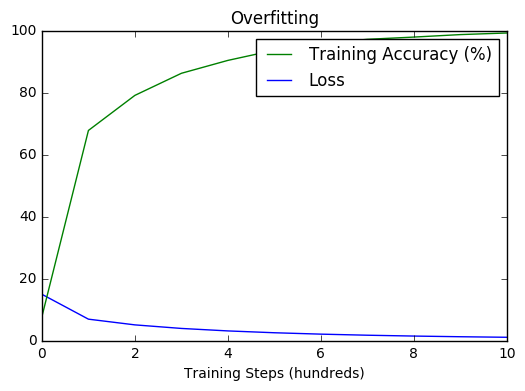

In [15]:
""" LINEAR NEURAL NETWORK """

# Variables
steps_num = 1001
subset = 500
flat_data_size = img_size * img_size * channels_num
train_accuracies = []
valid_accuracies = []
losses = []

# Graph
graph = tf.Graph()
with graph.as_default():
    # Reshape data
    train_X_flat = train_X.reshape((-1, flat_data_size))
    
    # Data
    train_X_tf = tf.placeholder(tf.float32, (subset, flat_data_size))
    train_y_tf = tf.placeholder(tf.float32, (subset, digits_num, labels_num))

    # Weights
    weights_1 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_2 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_3 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_4 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_5 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))

    # Biases
    bias_1 = tf.Variable(tf.zeros(labels_num))
    bias_2 = tf.Variable(tf.zeros(labels_num))
    bias_3 = tf.Variable(tf.zeros(labels_num))
    bias_4 = tf.Variable(tf.zeros(labels_num))
    bias_5 = tf.Variable(tf.zeros(labels_num))

    # Model
    def model(data):
        logits_1 = tf.matmul(data, weights_1) + bias_1
        logits_2 = tf.matmul(data, weights_2) + bias_2
        logits_3 = tf.matmul(data, weights_3) + bias_3
        logits_4 = tf.matmul(data, weights_4) + bias_4
        logits_5 = tf.matmul(data, weights_5) + bias_5
        return (logits_1, logits_2, logits_3, logits_4, logits_5)

    # Logits
    (train_logits_1, train_logits_2, train_logits_3, train_logits_4, train_logits_5) = model(train_X_tf)
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_5, train_y_tf[:,4,:]))

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_logits_1), 
                          tf.nn.softmax(train_logits_2), 
                          tf.nn.softmax(train_logits_3), 
                          tf.nn.softmax(train_logits_4), 
                          tf.nn.softmax(train_logits_5)), 1)
    
# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    # Train
    for i in xrange(steps_num):
        batch_X = train_X_flat[:subset,:]
        batch_y = train_y[:subset,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)
        
        # Report training accuracy        
        if i % 100 == 0:
            train_accuracy = accuracy(preds, batch_y)
            train_accuracies.append(train_accuracy)
            losses.append(l)
            print('Step %d: Loss = %.2f, Training accuracy = %.2f%%\n' % (i, l, train_accuracy))
    
# Plot training graph to access under/overfitting
l, = plt.plot(losses, label='Loss')
ta, = plt.plot(train_accuracies, label='Training Accuracy (%)')
plt.xlabel('Training Steps (hundreds)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('Overfitting')
plt.legend(handles=[ta, l])
plt.show()

Step 100: Loss = 12.16, Training accuracy = 41.88%, Validation accuracy = 42.23%

Step 200: Loss = 11.98, Training accuracy = 36.25%, Validation accuracy = 44.83%

Step 300: Loss = 10.06, Training accuracy = 51.88%, Validation accuracy = 47.44%

Step 400: Loss = 10.45, Training accuracy = 47.50%, Validation accuracy = 49.36%

Step 500: Loss = 10.78, Training accuracy = 41.88%, Validation accuracy = 49.94%

Step 600: Loss = 9.28, Training accuracy = 56.25%, Validation accuracy = 51.30%

Step 700: Loss = 9.28, Training accuracy = 51.88%, Validation accuracy = 52.47%

Step 800: Loss = 9.35, Training accuracy = 48.75%, Validation accuracy = 52.29%

Step 900: Loss = 8.56, Training accuracy = 54.38%, Validation accuracy = 53.22%

Step 1000: Loss = 8.17, Training accuracy = 61.88%, Validation accuracy = 55.53%

Test set accuracy = 54.91%


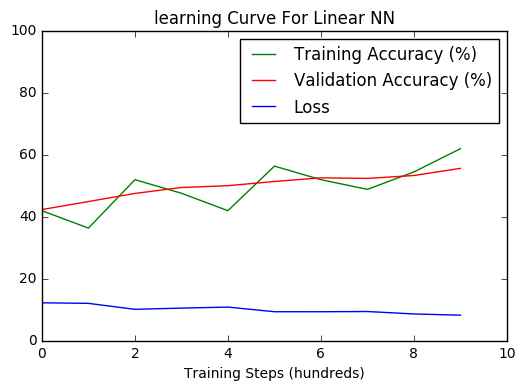

In [182]:
""" LINEAR NEURAL NETWORK """

# Variables
batch_size = 32
reg_constant = 0.001
steps_num = 101
flat_data_size = img_size * img_size * channels_num
train_accuracies = []
valid_accuracies = []
losses = []

# Graph
graph = tf.Graph()
with graph.as_default():
    # Data
    train_X_flat = train_X.reshape((-1, flat_data_size))
    valid_X_flat = valid_X.reshape((-1, flat_data_size))
    test_X_flat = test_X.reshape((-1, flat_data_size))
    
    with tf.name_scope('data') as scope:
        train_X_tf = tf.placeholder(tf.float32, (batch_size, flat_data_size), name='train_X_tf')
        train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num), name='train_y_tf')
        valid_X_tf = tf.constant(valid_X_flat, name='valid_X_tf')
        test_X_tf = tf.constant(test_X_flat, name='test_X_tf')

    # Weights
    with tf.name_scope('weights') as scope:
        weights_1 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_1')
        weights_2 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_2')
        weights_3 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_3')
        weights_4 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_4')
        weights_5 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_5')

    # Biases
    with tf.name_scope('biases') as scope:
        bias_1 = tf.Variable(tf.zeros(labels_num), name='bias_1')
        bias_2 = tf.Variable(tf.zeros(labels_num), name='bias_2')
        bias_3 = tf.Variable(tf.zeros(labels_num), name='bias_3')
        bias_4 = tf.Variable(tf.zeros(labels_num), name='bias_4')
        bias_5 = tf.Variable(tf.zeros(labels_num), name='bias_5')

    # Model
    def model(data):
        logits_1 = tf.matmul(data, weights_1) + bias_1
        logits_2 = tf.matmul(data, weights_2) + bias_2
        logits_3 = tf.matmul(data, weights_3) + bias_3
        logits_4 = tf.matmul(data, weights_4) + bias_4
        logits_5 = tf.matmul(data, weights_5) + bias_5
        return (logits_1, logits_2, logits_3, logits_4, logits_5)

    # Logits
    (train_logits_1, train_logits_2, train_logits_3, train_logits_4, train_logits_5) = model(train_X_tf)
    (valid_logits_1, valid_logits_2, valid_logits_3, valid_logits_4, valid_logits_5) = model(valid_X_tf)
    (test_logits_1, test_logits_2, test_logits_3, test_logits_4, test_logits_5) = model(test_X_tf)
    
    # Loss
    with tf.name_scope('loss') as scope:
        regularization = reg_constant * (tf.nn.l2_loss(weights_1) + 
                                         tf.nn.l2_loss(weights_2) + 
                                         tf.nn.l2_loss(weights_3) + 
                                         tf.nn.l2_loss(weights_4) + 
                                         tf.nn.l2_loss(weights_5))
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits_1, train_y_tf[:,0,:]) + 
                              tf.nn.softmax_cross_entropy_with_logits(train_logits_2, train_y_tf[:,1,:]) + 
                              tf.nn.softmax_cross_entropy_with_logits(train_logits_3, train_y_tf[:,2,:]) + 
                              tf.nn.softmax_cross_entropy_with_logits(train_logits_4, train_y_tf[:,3,:]) + 
                              tf.nn.softmax_cross_entropy_with_logits(train_logits_5, train_y_tf[:,4,:]) + 
                              regularization)

        # Optimizer
        optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_logits_1), 
                          tf.nn.softmax(train_logits_2), 
                          tf.nn.softmax(train_logits_3), 
                          tf.nn.softmax(train_logits_4), 
                          tf.nn.softmax(train_logits_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_logits_1), 
                          tf.nn.softmax(valid_logits_2), 
                          tf.nn.softmax(valid_logits_3), 
                          tf.nn.softmax(valid_logits_4), 
                          tf.nn.softmax(valid_logits_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_logits_1), 
                         tf.nn.softmax(test_logits_2), 
                         tf.nn.softmax(test_logits_3), 
                         tf.nn.softmax(test_logits_4), 
                         tf.nn.softmax(test_logits_5)), 1)

# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    for i in xrange(steps_num):
        # Get batch data and labels
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X_flat[batch_start:batch_end,:]
        batch_y = train_y[batch_start:batch_end,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)
        
        # Report validation accuracy
        if i % 100 == 0 and i != 0:
            train_accuracy = accuracy(preds, batch_y)
            valid_accuracy = accuracy(valid_preds.eval(), valid_y)
            train_accuracies.append(train_accuracy)
            valid_accuracies.append(valid_accuracy)
            losses.append(l)
            print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
                  (i, l, train_accuracy, valid_accuracy))
    
    print('Test set accuracy = %.2f%%' % accuracy(test_preds.eval(), test_y))
        
# Plot training graph to access performance
l, = plt.plot(losses, label='Loss')
ta, = plt.plot(train_accuracies, label='Training Accuracy (%)')
va, = plt.plot(valid_accuracies, label='Validation Accuracy (%)')
plt.xlabel('Training Steps (hundreds)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('learning Curve For Linear NN')
plt.legend(handles=[ta, va, l])
plt.show()

# Cite source: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:980px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
show_graph(graph)

Step 0: Loss = 34.62, Training accuracy = 8.75%, Validation accuracy = 40.29%

Step 100: Loss = 7.82, Training accuracy = 58.75%, Validation accuracy = 60.54%

Step 200: Loss = 7.32, Training accuracy = 55.00%, Validation accuracy = 60.93%

Step 300: Loss = 6.83, Training accuracy = 62.50%, Validation accuracy = 61.30%

Step 400: Loss = 6.18, Training accuracy = 62.50%, Validation accuracy = 61.40%

Step 500: Loss = 7.05, Training accuracy = 57.50%, Validation accuracy = 61.40%

Step 600: Loss = 7.39, Training accuracy = 61.25%, Validation accuracy = 61.39%

Step 700: Loss = 7.33, Training accuracy = 60.62%, Validation accuracy = 61.40%

Step 800: Loss = 6.76, Training accuracy = 56.25%, Validation accuracy = 61.41%

Step 900: Loss = 6.09, Training accuracy = 64.38%, Validation accuracy = 61.42%

Step 1000: Loss = 6.17, Training accuracy = 63.75%, Validation accuracy = 61.43%

Test set accuracy = 65.81%


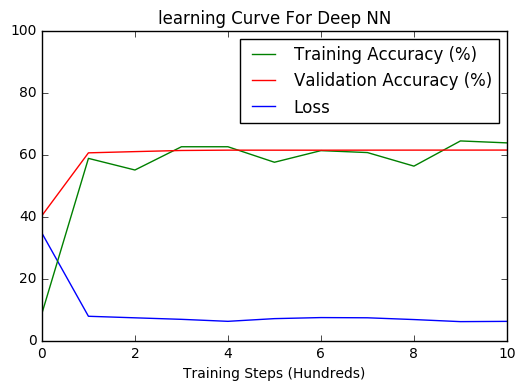

In [19]:
""" DEEP NEURAL NETWORK """

# Hyperparameters
batch_size = 32
reg_constant = 0.001
dropout_rate = 0.5
steps_num = 1001
flat_data_size = img_size * img_size * channels_num
hidden_first_nodes = 1024
hidden_second_nodes = 128
train_accuracies = []
valid_accuracies = []
losses = []

# Graph
graph = tf.Graph()
with graph.as_default():
    # Data
    train_X_flat = train_X.reshape((-1, flat_data_size))
    valid_X_flat = valid_X.reshape((-1, flat_data_size))
    test_X_flat = test_X.reshape((-1, flat_data_size))
    train_X_tf = tf.placeholder(tf.float32, (batch_size, flat_data_size))
    train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    valid_X_tf = tf.constant(valid_X_flat)
    test_X_tf = tf.constant(test_X_flat)

    # First hidden weights
    weights_hidden_first = tf.Variable(tf.random_normal((flat_data_size, hidden_first_nodes), stddev=0.1))

    # First hidden biases
    biases_hidden_first = tf.Variable(tf.zeros(hidden_first_nodes))
    
    # Second hidden weights
    weights_hidden_second = tf.Variable(tf.random_normal((hidden_first_nodes, hidden_second_nodes), stddev=0.1))

    # Second hidden biases
    biases_hidden_second = tf.Variable(tf.zeros(hidden_second_nodes))
    
    # Output weights
    weights_output_1 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
    weights_output_2 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
    weights_output_3 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
    weights_output_4 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
    weights_output_5 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))

    # Output biases
    biases_output_1 = tf.Variable(tf.zeros(labels_num))
    biases_output_2 = tf.Variable(tf.zeros(labels_num))
    biases_output_3 = tf.Variable(tf.zeros(labels_num))
    biases_output_4 = tf.Variable(tf.zeros(labels_num))
    biases_output_5 = tf.Variable(tf.zeros(labels_num)) 

    # Model
    def model(data, dropout):
        # Compute first hidden layer
        hidden_first = tf.nn.relu(tf.matmul(data, weights_hidden_first) + biases_hidden_first)
                            
        # Compute second hidden layer
        hidden_second = tf.nn.relu(tf.matmul(hidden_first, weights_hidden_second) + biases_hidden_second)
        
        # Dropout regularization
        if dropout:
            hidden_second = tf.nn.dropout(hidden_second, dropout_rate)
        
        # Compute output layer
        output_1 = tf.matmul(hidden_second, weights_output_1) + biases_output_1
        output_2 = tf.matmul(hidden_second, weights_output_2) + biases_output_2
        output_3 = tf.matmul(hidden_second, weights_output_3) + biases_output_3
        output_4 = tf.matmul(hidden_second, weights_output_4) + biases_output_4
        output_5 = tf.matmul(hidden_second, weights_output_5) + biases_output_5
    
        # Return outputs
        return (output_1, output_2, output_3, output_4, output_5)

    # Logits
    (train_output_1, train_output_2, train_output_3, train_output_4, train_output_5) = model(train_X_tf, True)
    (valid_output_1, valid_output_2, valid_output_3, valid_output_4, valid_output_5) = model(valid_X_tf, False)
    (test_output_1, test_output_2, test_output_3, test_output_4, test_output_5) = model(test_X_tf, False)
    
    # L2 regularization
    regularization = reg_constant * (tf.nn.l2_loss(weights_output_1) + 
                                     tf.nn.l2_loss(weights_output_2) + 
                                     tf.nn.l2_loss(weights_output_3) + 
                                     tf.nn.l2_loss(weights_output_4) + 
                                     tf.nn.l2_loss(weights_output_5))
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
                          regularization)

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_output_1), 
                          tf.nn.softmax(train_output_2), 
                          tf.nn.softmax(train_output_3), 
                          tf.nn.softmax(train_output_4), 
                          tf.nn.softmax(train_output_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
                          tf.nn.softmax(valid_output_2), 
                          tf.nn.softmax(valid_output_3), 
                          tf.nn.softmax(valid_output_4), 
                          tf.nn.softmax(valid_output_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_output_1), 
                         tf.nn.softmax(test_output_2), 
                         tf.nn.softmax(test_output_3), 
                         tf.nn.softmax(test_output_4), 
                         tf.nn.softmax(test_output_5)), 1)

# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    # Train
    for i in xrange(steps_num):
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X_flat[batch_start:batch_end,:]
        batch_y = train_y[batch_start:batch_end,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)        
        
        # Report validation accuracy
        if i % 100 == 0:
            train_accuracy = accuracy(preds, batch_y)
            valid_accuracy = accuracy(valid_preds.eval(), valid_y)
            train_accuracies.append(train_accuracy)
            valid_accuracies.append(valid_accuracy)
            losses.append(l)

            print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
                  (i, l, train_accuracy, valid_accuracy))
        
    print('Test set accuracy = %.2f%%' % accuracy(test_preds.eval(), test_y))
        
# Plot training graph to access performance
l, = plt.plot(losses, label='Loss')
ta, = plt.plot(train_accuracies, label='Training Accuracy (%)')
va, = plt.plot(valid_accuracies, label='Validation Accuracy (%)')
plt.xlabel('Training Steps (Hundreds)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('learning Curve For Deep NN')
plt.legend(handles=[ta, va, l])
plt.show()

Step 0: Loss = 52.29, Training accuracy = 4.38%, Validation accuracy = 57.77%

Step 100: Loss = 6.23, Training accuracy = 59.69%, Validation accuracy = 61.35%

Step 200: Loss = 5.67, Training accuracy = 64.06%, Validation accuracy = 61.97%

Step 300: Loss = 6.05, Training accuracy = 61.56%, Validation accuracy = 62.34%

Step 400: Loss = 5.27, Training accuracy = 67.81%, Validation accuracy = 63.08%

Step 500: Loss = 5.51, Training accuracy = 65.31%, Validation accuracy = 64.67%

Step 600: Loss = 5.41, Training accuracy = 65.62%, Validation accuracy = 66.79%

Step 700: Loss = 4.88, Training accuracy = 68.44%, Validation accuracy = 68.64%

Step 800: Loss = 4.90, Training accuracy = 68.75%, Validation accuracy = 69.82%

Step 900: Loss = 4.76, Training accuracy = 69.69%, Validation accuracy = 71.00%

Step 1000: Loss = 4.48, Training accuracy = 70.94%, Validation accuracy = 71.69%

Test set accuracy = 68.61%


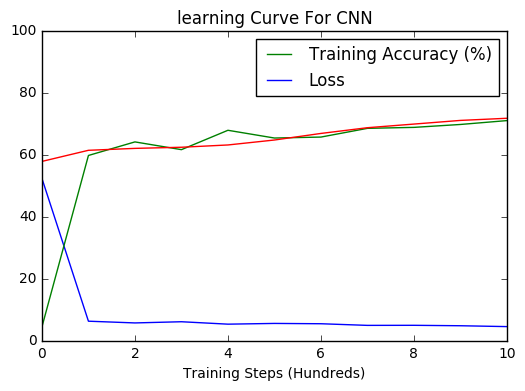

Training and evaluation took 10 minutes


In [27]:
""" CONVOLUTIONAL NEURAL NETWORK """

start = time.time()

# Hyperparameters
steps_num = 1001
batch_size = 32
patch_size = 5
conv_depth_1 = 16
conv_depth_2 = 32
full_nodes = 512
reg_constant = 0.001
dropout_rate = 0.5
train_accuracies = []
valid_accuracies = []
losses = []
conv_stride = 1
pool_window_size = [1, 2, 2, 1]
pool_stride = [1, 2, 2, 1]
padding = 'SAME'

# Helper functions
def create_weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def create_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

def create_conv_layer(data, weights):
    return tf.nn.conv2d(data, weights, [1, conv_stride, conv_stride, 1], padding)

def create_pool_layer(data):
    return tf.nn.max_pool(data, pool_window_size, pool_stride, padding)

def get_conv_shape(data_shape, weights_shape):
    if padding == 'VALID':
        new_height = int(np.ceil((data_shape[1] - weights_shape[0] + 1) / conv_stride))
        new_width = int(np.ceil((data_shape[2] - weights_shape[1] + 1) / conv_stride))
    else:
        new_height = int(np.ceil(data_shape[1] / conv_stride))
        new_width = int(np.ceil(data_shape[2] / conv_stride))
    return (data_shape[0], new_height, new_width, weights_shape[3])

def get_pool_shape(data_shape):
    new_height = int(np.ceil(data_shape[1] / pool_stride[1]))
    new_width = int(np.ceil(data_shape[2] / pool_stride[2]))
    return (data_shape[0], new_height, new_width, data_shape[3])

# Graph
graph = tf.Graph()
with graph.as_default():
    
    # Data (don't flatten as we did before)
    train_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    valid_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    valid_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    test_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    test_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))

    # First convolution layer weights
    weights_conv_first = create_weight((patch_size, patch_size, channels_num, conv_depth_1))
        
    # First convolution layer biases
    biases_conv_first = create_bias((conv_depth_1,))

    # Second convolution layer weights
    weights_conv_second = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))

    # Second convolution layer biases
    biases_conv_second = create_bias((conv_depth_2,))

    # Calculate final pooled layer shape
    conv_first_shape = get_conv_shape(train_X_tf.get_shape().as_list(), weights_conv_first.get_shape().as_list())
    pool_first_shape = get_pool_shape(conv_first_shape)
    conv_second_shape = get_conv_shape(pool_first_shape, weights_conv_second.get_shape().as_list())
    pool_second_shape = get_pool_shape(conv_second_shape)
    final_pooled_flat = pool_second_shape[1] * pool_second_shape[2] * pool_second_shape[3]
        
    # Fully connected layer weights   
    weights_full = create_weight((final_pooled_flat, full_nodes))

    # Fully connected layer biases
    biases_full = create_bias((full_nodes,))
    
    # Output weights
    weights_output_1 = create_weight((full_nodes, labels_num))
    weights_output_2 = create_weight((full_nodes, labels_num))
    weights_output_3 = create_weight((full_nodes, labels_num))
    weights_output_4 = create_weight((full_nodes, labels_num))
    weights_output_5 = create_weight((full_nodes, labels_num))

    # Output biases
    biases_output_1 = create_bias((labels_num,))
    biases_output_2 = create_bias((labels_num,))
    biases_output_3 = create_bias((labels_num,))
    biases_output_4 = create_bias((labels_num,))
    biases_output_5 = create_bias((labels_num,)) 
    
    # Model
    def model(data, dropout):
        # First convolution layer
        conv_first = tf.nn.relu(create_conv_layer(data, weights_conv_first) + biases_conv_first)

        # First pooling layer
        pool_first = create_pool_layer(conv_first)
        
        # Second convolution layer
        conv_second = tf.nn.relu(create_conv_layer(pool_first, weights_conv_second) + biases_conv_second)

        # Second pooling layer
        pool_second = create_pool_layer(conv_second)
        
        # Reshape data
        data_size = pool_second.get_shape().as_list()[0]
        pool_second = tf.reshape(pool_second, (data_size, final_pooled_flat))
        
        # Fully connected layer
        full = tf.nn.relu(tf.matmul(pool_second, weights_full) + biases_full)
                
        # Dropout regularization (only during training)
        if dropout:
            full_1 = tf.nn.dropout(full, dropout_rate)

        # Output layer
        output_1 = tf.matmul(full, weights_output_1) + biases_output_1
        output_2 = tf.matmul(full, weights_output_2) + biases_output_2
        output_3 = tf.matmul(full, weights_output_3) + biases_output_3
        output_4 = tf.matmul(full, weights_output_4) + biases_output_4
        output_5 = tf.matmul(full, weights_output_5) + biases_output_5
    
        # Return outputs
        return (output_1, output_2, output_3, output_4, output_5)

    # Logits
    (train_output_1, train_output_2, train_output_3, train_output_4, train_output_5) = model(train_X_tf, True)
    (valid_output_1, valid_output_2, valid_output_3, valid_output_4, valid_output_5) = model(valid_X_tf, False)
    (test_output_1, test_output_2, test_output_3, test_output_4, test_output_5) = model(test_X_tf, False)
    
    # L2 regularization (only on fully connected layers)
    regularization = reg_constant * (tf.nn.l2_loss(weights_output_1) + 
                                     tf.nn.l2_loss(weights_output_2) + 
                                     tf.nn.l2_loss(weights_output_3) + 
                                     tf.nn.l2_loss(weights_output_4) + 
                                     tf.nn.l2_loss(weights_output_5))
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
                          regularization)

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_output_1), 
                          tf.nn.softmax(train_output_2), 
                          tf.nn.softmax(train_output_3), 
                          tf.nn.softmax(train_output_4), 
                          tf.nn.softmax(train_output_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
                          tf.nn.softmax(valid_output_2), 
                          tf.nn.softmax(valid_output_3), 
                          tf.nn.softmax(valid_output_4), 
                          tf.nn.softmax(valid_output_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_output_1), 
                         tf.nn.softmax(test_output_2), 
                         tf.nn.softmax(test_output_3), 
                         tf.nn.softmax(test_output_4), 
                         tf.nn.softmax(test_output_5)), 1)

# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    # Train
    for i in xrange(steps_num):
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X[batch_start:batch_end,:,:,:]
        batch_y = train_y[batch_start:batch_end,:,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)        

        # Report validation accuracy
        if i % 100 == 0:
            losses.append(l)
            train_accuracy = accuracy(preds, batch_y)
            train_accuracies.append(train_accuracy)
            
            valid_preds_total = np.ndarray(valid_y.shape)
            for j in xrange(int(np.floor(valid_y.shape[0] / batch_size))):
                batch_start_valid = batch_size * j
                batch_end_valid = batch_start_valid + batch_size
                batch_X_valid = valid_X[batch_start_valid:batch_end_valid,:,:,:]
                batch_y_valid = valid_y[batch_start_valid:batch_end_valid,:,:]                
                feed_dict = {valid_X_tf: batch_X_valid, valid_y_tf: batch_y_valid}
                valid_preds_total[batch_start_valid:batch_end_valid,:,:] = session.run(valid_preds, feed_dict) 
            
            valid_accuracy = accuracy(valid_preds_total, valid_y)
            valid_accuracies.append(valid_accuracy)            

            print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
                  (i, l, train_accuracy, valid_accuracy))
    
    test_preds_total = np.ndarray(test_y.shape)
    for j in xrange(int(np.floor(test_y.shape[0] / batch_size))):
        batch_start_test = batch_size * j
        batch_end_test = batch_start_test + batch_size
        batch_X_test = test_X[batch_start_test:batch_end_test,:,:,:]
        batch_y_test = test_y[batch_start_test:batch_end_test,:,:]                
        feed_dict = {test_X_tf: batch_X_test, test_y_tf: batch_y_test}
        test_preds_total[batch_start_test:batch_end_test,:,:] = session.run(test_preds, feed_dict) 

    print('Test set accuracy = %.2f%%' % accuracy(test_preds_total, test_y))
    
# Plot training graph to access performance
l, = plt.plot(losses, label='Loss')
ta, = plt.plot(train_accuracies, label='Training Accuracy (%)')
va, = plt.plot(valid_accuracies, label='Validation Accuracy (%)')
plt.xlabel('Training Steps (Hundreds)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('learning Curve For CNN')
plt.legend(handles=[ta, va, l])
plt.legend(handles=[ta, l])
plt.show()

end = time.time()
print('Training and evaluation took %d minutes' % int((end - start) / 60))